## Prep pGL2-BRI1-GFP seu object with metadata

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(ggplot2)
library(muscat)
library(purrr)
library(limma)
library(scran)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualizati

In [2]:
library(future)
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/tmn23/miniconda3/envs/muscat/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] future_1.31.0               scran_1.26.0               
 [3] scuttle_1.8.0               SingleCellExperiment_1.20.0
 [5] SummarizedExperiment_1.28.0 Biobase_2.58.0             
 [7] GenomicRanges_1.50.0        GenomeInfoDb_1.34.8        
 [9]

In [4]:
rc.integrated <- readRDS("../../CheWei/scRNA-seq/Integrated_Objects/rc.integrated_6S_GL2_lines_seu3_20240423.rds")

In [5]:
rc.integrated

An object of class Seurat 
71741 features across 37615 samples within 3 assays 
Active assay: SCT (24847 features, 0 variable features)
 2 other assays present: RNA, integrated
 3 dimensional reductions calculated: pca, umap, umap_2D

In [6]:
table(rc.integrated$orig.ident)


sc_130 sc_131 sc_133 sc_134 sc_135 sc_137 
  6656   7658   8424   7837   4975   2065 

In [7]:
rc.integrated$geno <- rc.integrated$orig.ident
rc.integrated$geno <- gsub("sc_130","WT",rc.integrated$geno)
rc.integrated$geno <- gsub("sc_134","WT",rc.integrated$geno)
rc.integrated$geno <- gsub("sc_131","bri1_T",rc.integrated$geno)
rc.integrated$geno <- gsub("sc_135","bri1_T",rc.integrated$geno)
rc.integrated$geno <- gsub("sc_133","pGL2_BRI1_GFP_bri1_T",rc.integrated$geno)
rc.integrated$geno <- gsub("sc_137","pGL2_BRI1_GFP_bri1_T",rc.integrated$geno)

In [8]:
rc.integrated$rep <- rc.integrated$orig.ident
rc.integrated$rep <- gsub("sc_130","1",rc.integrated$rep)
rc.integrated$rep <- gsub("sc_134","2",rc.integrated$rep)
rc.integrated$rep <- gsub("sc_131","1",rc.integrated$rep)
rc.integrated$rep <- gsub("sc_135","2",rc.integrated$rep)
rc.integrated$rep <- gsub("sc_133","1",rc.integrated$rep)
rc.integrated$rep <- gsub("sc_137","2",rc.integrated$rep)

In [9]:
table(rc.integrated$orig.ident, rc.integrated$geno)

        
         bri1_T pGL2_BRI1_GFP_bri1_T   WT
  sc_130      0                    0 6656
  sc_131   7658                    0    0
  sc_133      0                 8424    0
  sc_134      0                    0 7837
  sc_135   4975                    0    0
  sc_137      0                 2065    0

In [10]:
feature_names <- read_tsv("../data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()

Rows: 32833 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): AGI, Name, Type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
rc.integrated$geno <- factor(rc.integrated$geno, levels=c("WT", "bri1_T", "pGL2_BRI1_GFP_bri1_T"))

## Cell and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [12]:
rc.integrated$cell_type <- rc.integrated$celltype.anno.Li.crude
rc.integrated$time_zone <- rc.integrated$time.anno
rc.integrated$time_zone_cell_type <- rc.integrated$time.celltype.anno.Li.crude

In [13]:
table(rc.integrated$orig.ident, rc.integrated$cell_type)

        
         Atrichoblast Columella Cortex Endodermis Lateral Root Cap Pericycle
  sc_130         1468       893    982        520             1078       271
  sc_131         1405       669    800        595             1787       749
  sc_133         1421       605   1452        884             1684       332
  sc_134         1195       588    924        639             2136       665
  sc_135         1040       287    541        525              963       407
  sc_137          351       282    293        236              421       134
        
         Phloem Procambium Trichoblast Xylem
  sc_130     57        190        1021   176
  sc_131    119        331         944   259
  sc_133     54        145        1669   178
  sc_134    123        353         937   277
  sc_135    106        211         707   188
  sc_137     27         68         197    56

In [14]:
table(rc.integrated$time.anno)


         Distal Columella   Distal Lateral Root Cap                Elongation 
                     2943                      2941                     10498 
               Maturation                  Meristem        Proximal Columella 
                     7025                      8801                       359 
Proximal Lateral Root Cap 
                     5048 

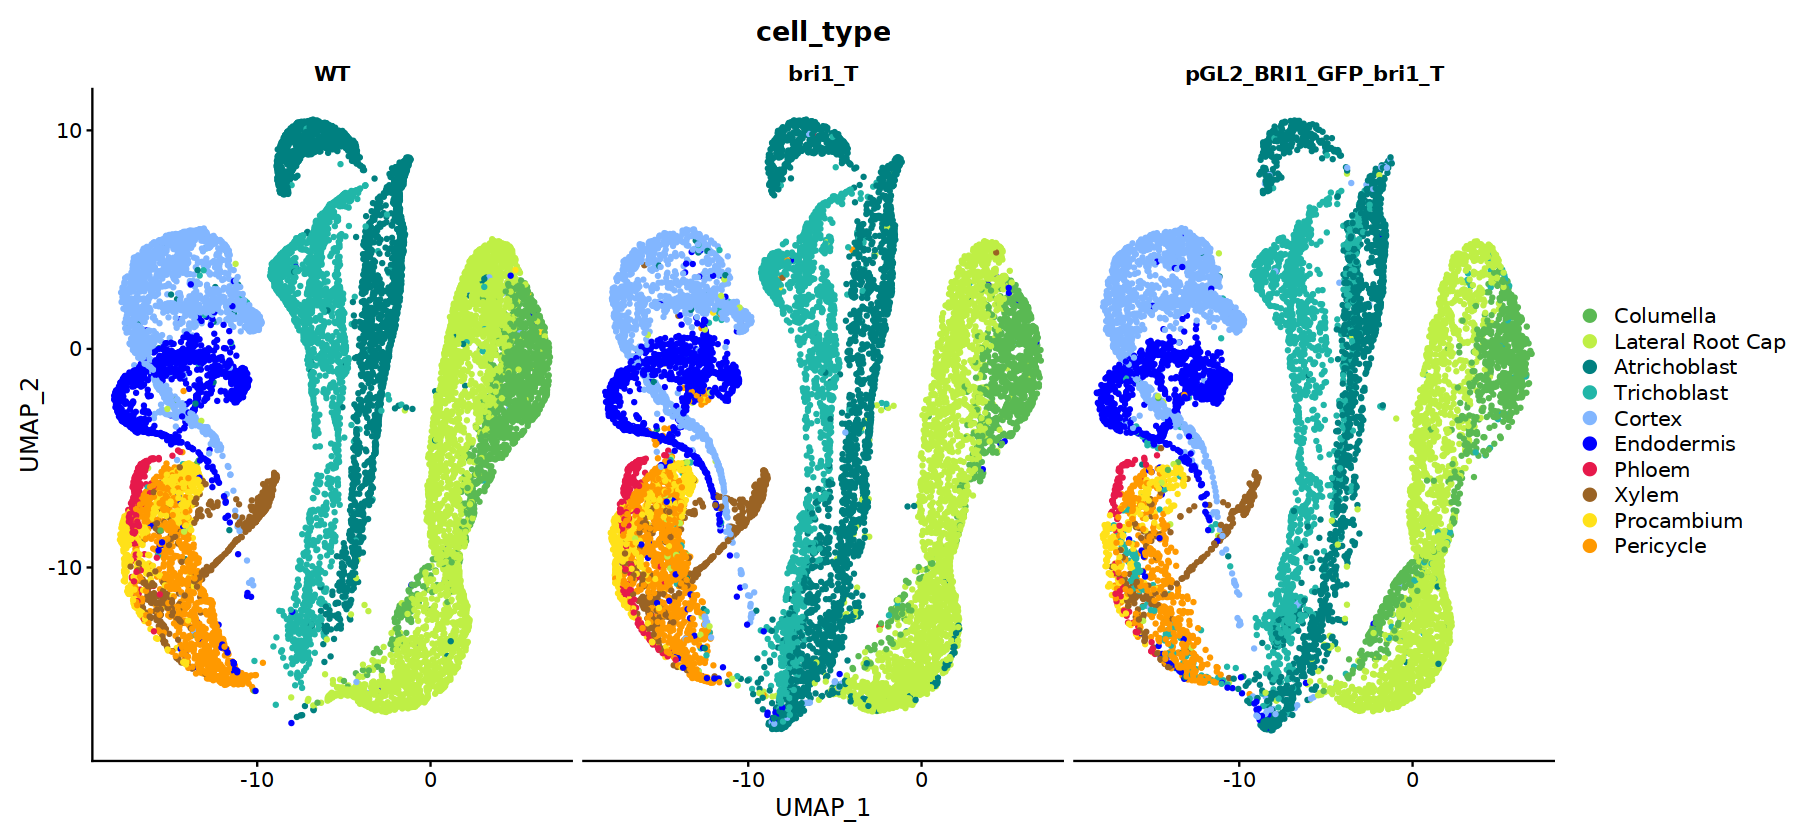

In [15]:
# Plot celltype annotation Li
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400D3", "#DCD0FF","#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#E6194B", "#DD77EC", "#9A6324", "#FFE119", "#FF9900", "#FFD4E3", "#9A6324", "#DDAA6F", "#EEEEEE")
rc.integrated$cell_type <- factor(rc.integrated$cell_type, levels = order[sort(match(unique(rc.integrated$cell_type),order))])
color <- palette[sort(match(unique(rc.integrated$cell_type),order))]


options(repr.plot.width=15, repr.plot.height=7)

(BR_cell <- DimPlot(rc.integrated, reduction = "umap", group.by = "cell_type", cols = color, split.by = 'geno', pt.size = 0.75, ncol=3)) 
ggsave("../output/GL2/pGL2_BRI1-GFP_cell_types.pdf", width=13, height=6)

Warning message in FeaturePlot(rc.integrated, features = "GL2-BRI1-GFP", split.by = "geno", :
“All cells have the same value (0) of GL2-BRI1-GFP.”


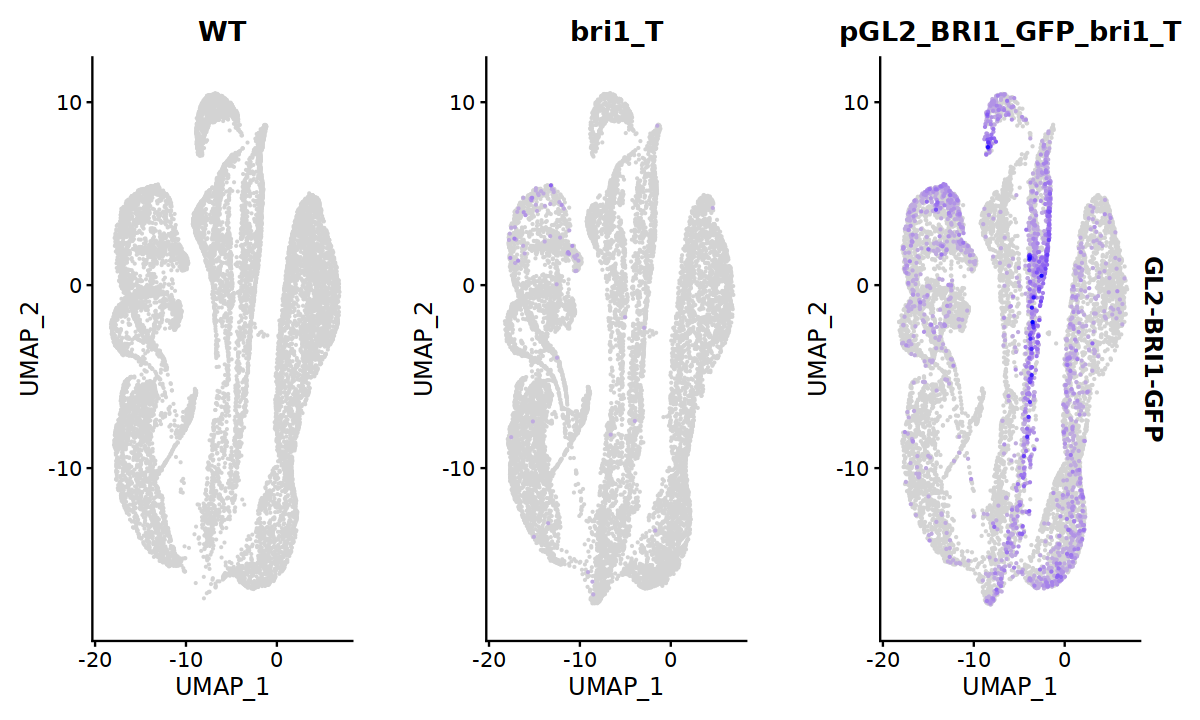

In [16]:
options(repr.plot.width=10, repr.plot.height=6)
FeaturePlot(rc.integrated, features="GL2-BRI1-GFP", split.by = "geno", order=T)
#ggsave("../output/GL2/pGL2_BRI1-GFP_expression.pdf", width=10, height=6)

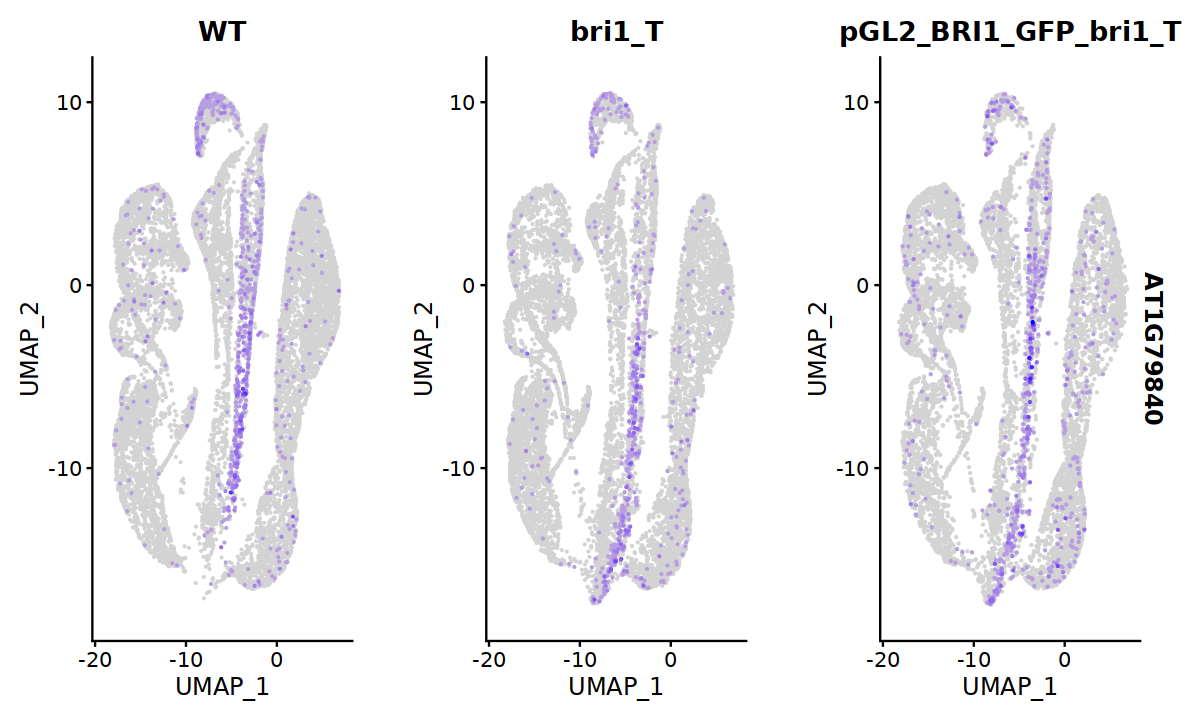

In [17]:
options(repr.plot.width=10, repr.plot.height=6)
FeaturePlot(rc.integrated, features="AT1G79840", split.by = "geno", order=T)
#ggsave("../output/GL2/GL2-AT1G79840_expression.pdf", width=10, height=6)

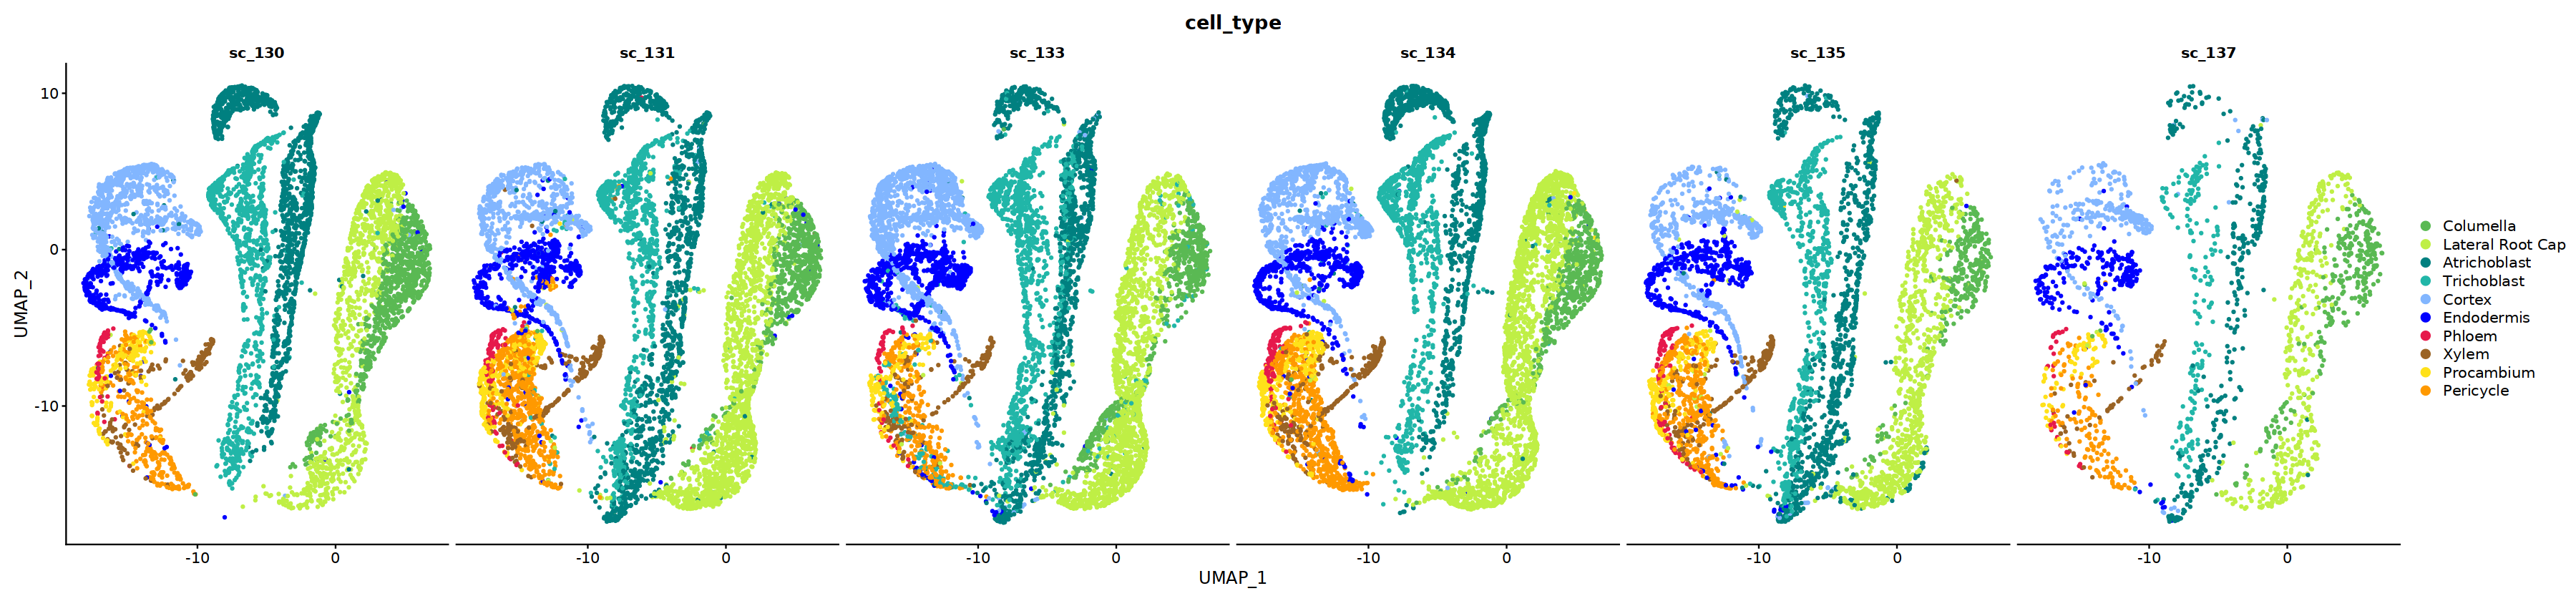

In [18]:
options(repr.plot.width=30, repr.plot.height=7)

(BR_cell <- DimPlot(rc.integrated, reduction = "umap", group.by = "cell_type", cols = color, split.by = 'orig.ident', pt.size = 0.75, ncol=8)) 

Warning message in FeaturePlot(rc.integrated, features = "GL2-BRI1-GFP", split.by = "orig.ident", :
“All cells have the same value (0) of GL2-BRI1-GFP.”
Warning message in FeaturePlot(rc.integrated, features = "GL2-BRI1-GFP", split.by = "orig.ident", :
“All cells have the same value (0) of GL2-BRI1-GFP.”


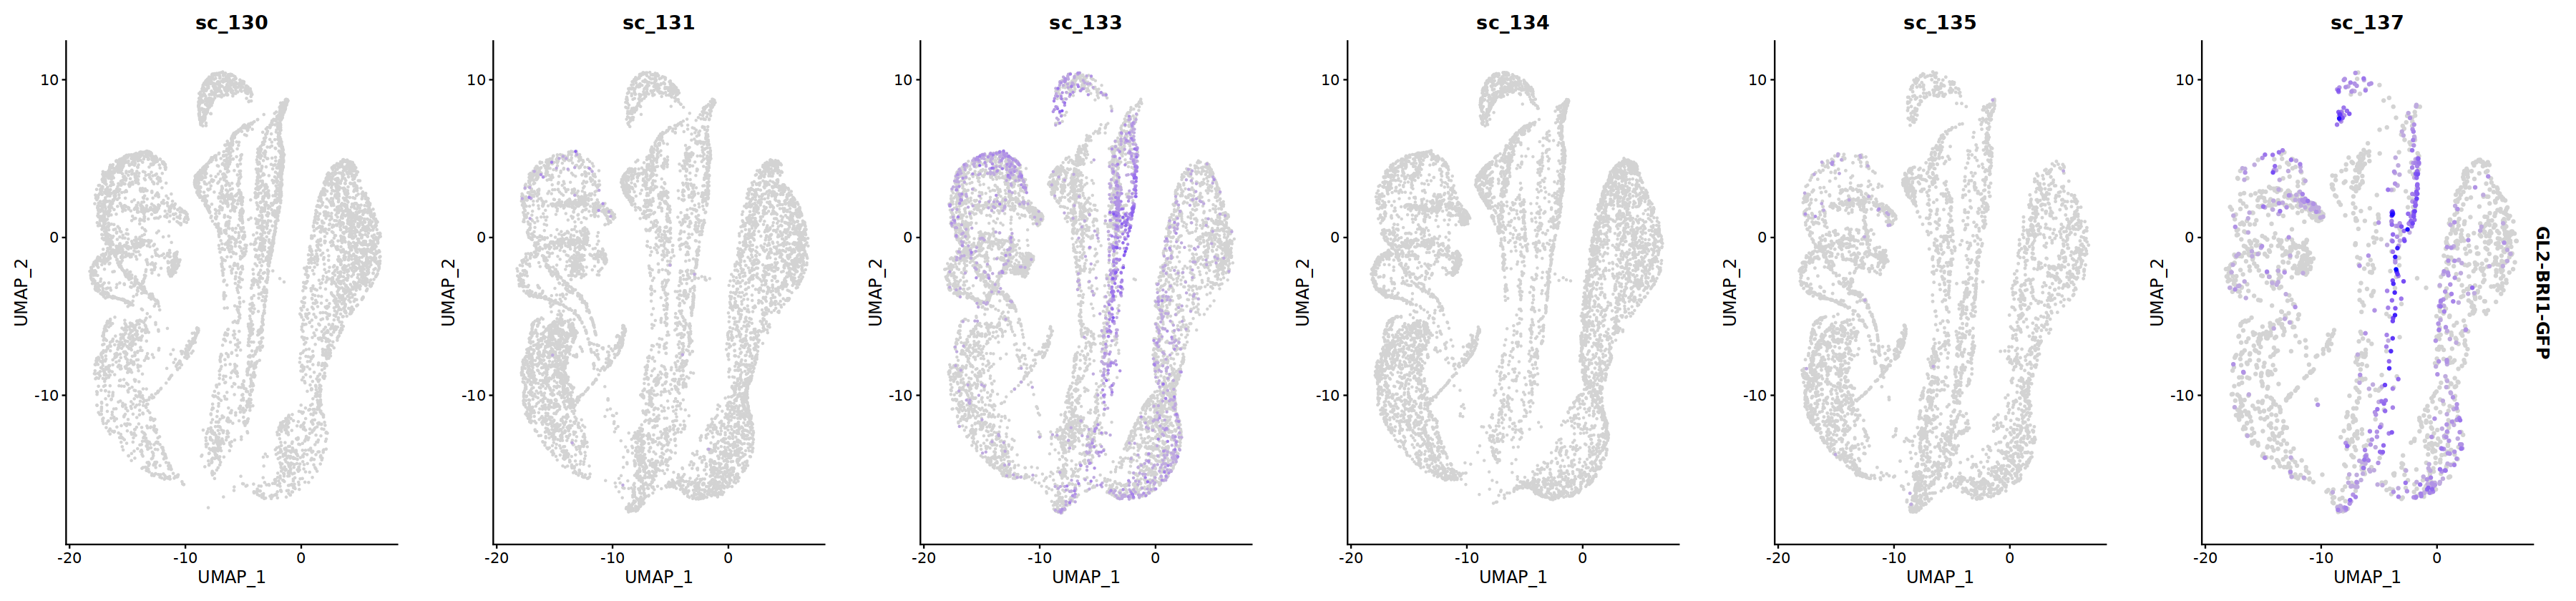

In [19]:
DefaultAssay(rc.integrated) <- "SCT"
FeaturePlot(rc.integrated, features="GL2-BRI1-GFP", split.by = "orig.ident", order=T)

In [20]:
saveRDS(rc.integrated, file = "/hpc/group/pbenfeylab/CheWei/scRNA-seq/Integrated_Objects/rc.integrated_6S_GL2_lines_seu4_annotated_20240429.rds")